# [**Comparaison du TargetEncoder avec d'autres encodeurs**](https://nbviewer.org/github/Franck-PepperLabs/pepper_dsia_skl_doc_fr/blob/main/docs/examples/6_3_preprocessing/plot_target_encoder.ipynb)<br/>([_Comparing Target Encoder with Other Encoders_](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_target_encoder.html))

Le [**`TargetEncoder`**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.TargetEncoder.html#sklearn.preprocessing.TargetEncoder) utilise la valeur de la cible pour encoder chaque caractéristique catégorielle. Dans cet exemple, nous allons comparer trois approches différentes pour gérer les caractéristiques catégorielles : [**`TargetEncoder`**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.TargetEncoder.html), [**`OrdinalEncoder`**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html), [**`OneHotEncoder`**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) et la suppression de la catégorie.

> **Remarque** **`fit(X, y).transform(X)`** n'est pas équivalent à **`fit_transform(X, y)`** car un schéma d'ajustement croisé est utilisé dans **`fit_transform`** pour l'encodage. Voir le Guide de l'utilisateur (6.3) pour plus de détails.

# Chargement des données depuis OpenML

Tout d'abord, nous chargeons l'ensemble de données sur les critiques de vin, où la cible est le nombre de points attribués par un critique :

In [1]:
from sklearn.datasets import fetch_openml

wine_reviews = fetch_openml(data_id=42074, as_frame=True, parser="pandas")

df = wine_reviews.frame
df.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


Pour cet exemple, nous utilisons le sous-ensemble de caractéristiques numériques et catégorielles suivantes dans les données. La cible est constituée de valeurs continues de 80 à 100 :

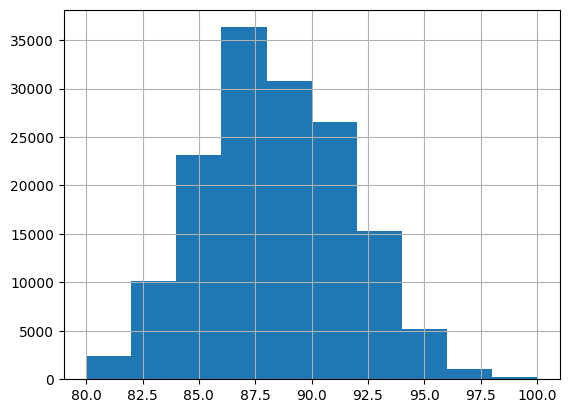

In [2]:
numerical_features = ["price"]
categorical_features = [
    "country",
    "province",
    "region_1",
    "region_2",
    "variety",
    "winery",
]
target_name = "points"

X = df[numerical_features + categorical_features]
y = df[target_name]

_ = y.hist()

# Entraînement et évaluation des pipelines avec différents encodeurs

Dans cette section, nous évaluons des pipelines avec le [**`HistGradientBoostingRegressor`**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html) en utilisant différentes stratégies d'encodage. Tout d'abord, nous listons les encodeurs que nous allons utiliser pour prétraiter les caractéristiques catégorielles :

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, TargetEncoder

categorical_preprocessors = [
    ("drop", "drop"),
    ("ordinal", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)),
    (
        "one_hot",
        OneHotEncoder(handle_unknown="ignore", max_categories=20, sparse_output=False),
    ),
    ("target", TargetEncoder(target_type="continuous")),
]

Ensuite, nous évaluons les modèles à l'aide de la validation croisée et enregistrons les résultats :

In [5]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline

n_cv_folds = 3
max_iter = 20
results = []


def evaluate_model_and_store(name, pipe):
    result = cross_validate(
        pipe,
        X,
        y,
        scoring="neg_root_mean_squared_error",
        cv=n_cv_folds,
        return_train_score=True,
    )
    rmse_test_score = -result["test_score"]
    rmse_train_score = -result["train_score"]
    results.append(
        {
            "preprocessor": name,
            "rmse_test_mean": rmse_test_score.mean(),
            "rmse_test_std": rmse_train_score.std(),
            "rmse_train_mean": rmse_train_score.mean(),
            "rmse_train_std": rmse_train_score.std(),
        }
    )


for name, categorical_preprocessor in categorical_preprocessors:
    preprocessor = ColumnTransformer(
        [
            ("numerical", "passthrough", numerical_features),
            ("categorical", categorical_preprocessor, categorical_features),
        ]
    )
    pipe = make_pipeline(
        preprocessor, HistGradientBoostingRegressor(random_state=0, max_iter=max_iter)
    )
    evaluate_model_and_store(name, pipe)

# Prise en charge native des caractéristiques catégorielles

Dans cette section, nous construisons et évaluons un pipeline qui utilise la prise en charge native des caractéristiques catégorielles dans le [**`HistGradientBoostingRegressor`**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html), qui ne prend en charge que jusqu'à 255 catégories uniques. Dans notre jeu de données, la plupart des caractéristiques catégorielles ont plus de 255 catégories uniques :

In [6]:
n_unique_categories = df[categorical_features].nunique().sort_values(ascending=False)
n_unique_categories

winery      14810
region_1     1236
variety       632
province      455
country        48
region_2       18
dtype: int64

Pour contourner la limitation ci-dessus, nous regroupons les caractéristiques catégorielles en fonction de leur faible ou grande cardinalité. Les caractéristiques à grande cardinalité seront encodées par la cible et les caractéristiques à faible cardinalité utiliseront la prise en charge native des caractéristiques catégorielles dans le gradient boosting.

In [7]:
high_cardinality_features = n_unique_categories[n_unique_categories > 255].index
low_cardinality_features = n_unique_categories[n_unique_categories <= 255].index
mixed_encoded_preprocessor = ColumnTransformer(
    [
        ("numerical", "passthrough", numerical_features),
        (
            "high_cardinality",
            TargetEncoder(target_type="continuous"),
            high_cardinality_features,
        ),
        (
            "low_cardinality",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
            low_cardinality_features,
        ),
    ],
    verbose_feature_names_out=False,
)

# The output of the of the preprocessor must be set to pandas so the
# gradient boosting model can detect the low cardinality features.
mixed_encoded_preprocessor.set_output(transform="pandas")
mixed_pipe = make_pipeline(
    mixed_encoded_preprocessor,
    HistGradientBoostingRegressor(
        random_state=0, max_iter=max_iter, categorical_features=low_cardinality_features
    ),
)
mixed_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                  ['price']),
                                                 ('high_cardinality',
                                                  TargetEncoder(target_type='continuous'),
                                                  Index(['winery', 'region_1', 'variety', 'province'], dtype='object')),
                                                 ('low_cardinality',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['country', 'region_2'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(categorical_features=Index(['country', 'region_2'], dtype='object'),
                                               max_iter=20, random_state=0))])

Enfin, nous évaluons le pipeline à l'aide de la validation croisée et enregistrons les résultats :

In [8]:
evaluate_model_and_store("mixed_target", mixed_pipe)

# Tracé des résultats

Dans cette section, nous affichons les résultats en traçant les scores de test et d'entraînement :

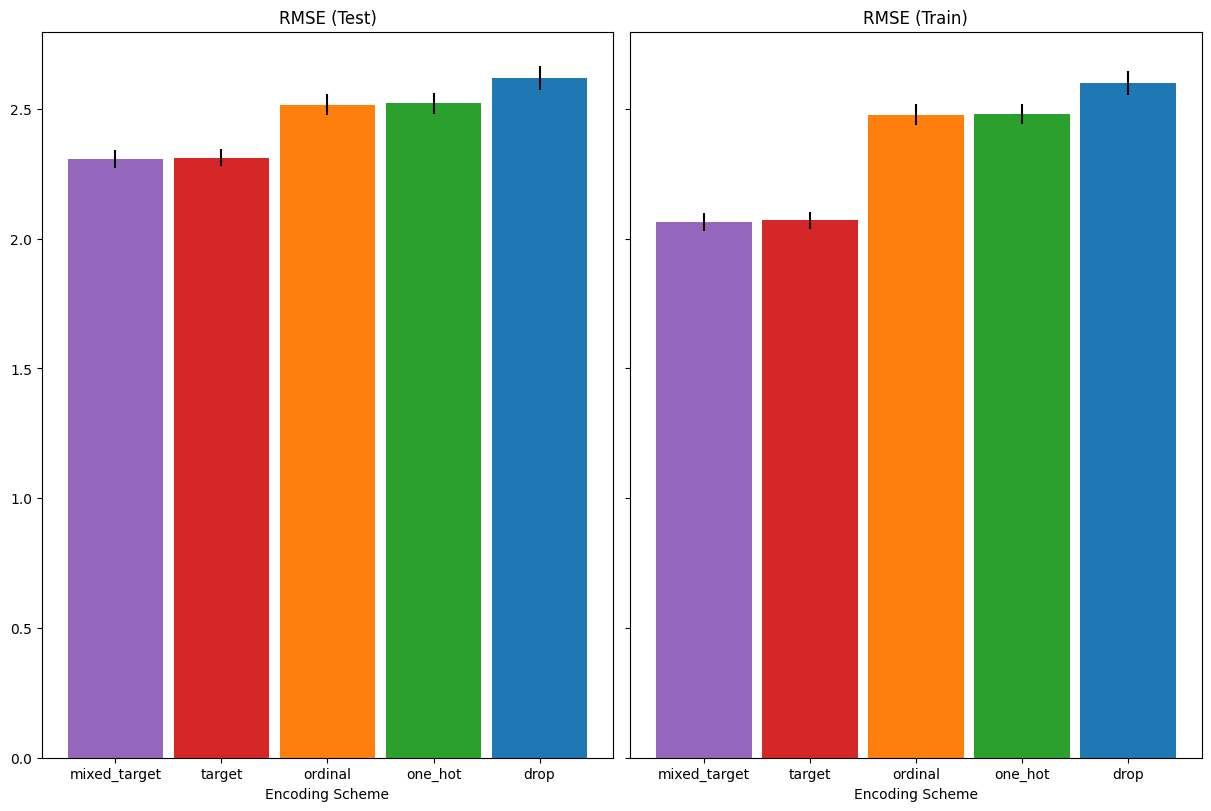

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

results_df = (
    pd.DataFrame(results).set_index("preprocessor").sort_values("rmse_test_mean")
)

fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(12, 8), sharey=True, constrained_layout=True
)
xticks = range(len(results_df))
name_to_color = dict(
    zip((r["preprocessor"] for r in results), ["C0", "C1", "C2", "C3", "C4"])
)

for subset, ax in zip(["test", "train"], [ax1, ax2]):
    mean, std = f"rmse_{subset}_mean", f"rmse_{subset}_std"
    data = results_df[[mean, std]].sort_values(mean)
    ax.bar(
        x=xticks,
        height=data[mean],
        yerr=data[std],
        width=0.9,
        color=[name_to_color[name] for name in data.index],
    )
    ax.set(
        title=f"RMSE ({subset.title()})",
        xlabel="Encoding Scheme",
        xticks=xticks,
        xticklabels=data.index,
    )

Lors de l'évaluation des performances prédictives sur l'ensemble de test, la suppression des catégories donne les résultats les plus mauvais et le TargetEncoder donne les meilleurs résultats. Cela peut s'expliquer comme suit :

- La suppression des caractéristiques catégorielles rend le pipeline moins expressif et entraîne un sous-ajustement ;
- En raison de la grande cardinalité et pour réduire le temps d'entraînement, le schéma d'encodage one-hot utilise `max_categories=20`, ce qui limite l'expansion des caractéristiques pour éviter le sous-ajustement.
- Si nous n'avions pas défini `max_categories=20`, le schéma d'encodage one-hot aurait probablement entraîné un surajustement du pipeline car le nombre de caractéristiques aurait explosé avec des occurrences de catégories rares qui sont corrélées avec la cible par hasard (uniquement sur l'ensemble d'entraînement) ;
- L'encodage ordinal impose un ordre arbitraire aux caractéristiques qui sont ensuite traitées comme des valeurs numériques par le [**`HistGradientBoostingRegressor`**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html). Étant donné que ce modèle regroupe les caractéristiques numériques en 256 intervalles par caractéristique, de nombreuses catégories non liées peuvent être regroupées, ce qui entraîne un sous-ajustement global du pipeline ;
- Lorsque l'on utilise l'encodeur de cible, le même regroupement se produit, mais étant donné que les valeurs encodées sont statistiquement ordonnées par association marginale avec la variable cible, le regroupement utilisé par le [**`HistGradientBoostingRegressor`**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html) a du sens et conduit à de bons résultats : la combinaison de l'encodage cible lissé et du regroupement fonctionne comme une bonne stratégie de régularisation contre le surajustement sans limiter trop la capacité expressive du pipeline.